In [27]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [28]:
df=pd.read_parquet("ori_df.parquet")
df.columns

Index(['Tail_Number', 'prev_arr_dt', 'prev_arr_delay', 'prev_origin',
       'prev_dest', 'prev_crs_dep', 'prev_crs_arr', 'next_dep_dt', 'DepDelay',
       'next_origin', 'Dest', 'next_crs_dep', 'next_crs_arr', 'turn_time_min',
       'O-D', 'historical_turn_time_min_3mean', 'scheduled_turn_time',
       'realized slack', 'scheturn_bucket', 'prev_bin', 'op_carrier',
       'op_flight', 'Origin', 'carrier_slope', 'origin_slope', 'crsdep_hour',
       'dep_hour', 'prev_arr_hour', 'datetime', 'temperature_2m',
       'wind_speed_10m', 'wind_gusts_10m', 'precipitation', 'is_day',
       'cloud_cover', 'airport', 'datetime_pa', 'temperature_2m_pa',
       'wind_speed_10m_pa', 'wind_gusts_10m_pa', 'precipitation_pa',
       'is_day_pa', 'cloud_cover_pa', 'airport_pa', 'Distance',
       'DistanceGroup', 'CRSElapsedTime', 'DayOfWeek', 'dep_dt', 'FlightDate',
       'crsdep_tbin', 'prev_arr_tbin'],
      dtype='object')

In [29]:
y_label= "DepDelay"

numeric_cols = [
'prev_arr_delay',
 'historical_turn_time_min_3mean',
 'scheduled_turn_time',
 'realized slack',
 'carrier_slope',
 'origin_slope',
 'temperature_2m',
 'wind_speed_10m',
 'wind_gusts_10m',
 'precipitation',
 'cloud_cover',
 'temperature_2m_pa',
 'wind_speed_10m_pa',
 'wind_gusts_10m_pa',
 'precipitation_pa',
 'cloud_cover_pa',
 'Distance',
 'CRSElapsedTime',
]

cat_cols=[
 'prev_origin',
#  'prev_crs_arr',
 'Dest',
 'scheturn_bucket',
 'prev_bin',
 'op_carrier',
 'Origin',
#  'crsdep_hour',
 'prev_arr_tbin',
 'crsdep_tbin',
 'is_day',
'is_day_pa',
'DistanceGroup',
 'DayOfWeek']



Feature Engineering:

In [ ]:
import numpy as np
import pandas as pd

def add_advanced_features(df):
    df = df.copy()
    df["FlightDate"] = pd.to_datetime(df["FlightDate"])
    df = df.sort_values("FlightDate")


    df["slack_time"] = df["scheduled_turn_time"] - df["historical_turn_time_min_3mean"]

    df["prev_arr_delay_clip"] = df["prev_arr_delay"].clip(lower=-30, upper=180)

    df["scheduled_turn_capped"] = df["scheduled_turn_time"].clip(lower=5, upper=180)

    df["prop_prev_delay_over_planned_turn"] = (
        df["prev_arr_delay_clip"] / df["scheduled_turn_capped"]
    )

    df["prop_prev_delay_over_turn"] = df["prev_arr_delay_clip"] / (df["scheduled_turn_time"] + 1e-3)

    df["short_turn"] = (df["scheduled_turn_time"] < 45).astype(int)
    df["short_turn_prev_delay"] = df["short_turn"] * df["prev_arr_delay_clip"]


    df["wind_speed_diff"] = df["wind_speed_10m"] - df["wind_speed_10m_pa"]
    df["wind_gusts_diff"] = df["wind_gusts_10m"] - df["wind_gusts_10m_pa"]
    df["temp_diff"]       = df["temperature_2m"] - df["temperature_2m_pa"]
    df["precip_diff"]     = df["precipitation"] - df["precipitation_pa"]
    df["cloud_diff"]      = df["cloud_cover"] - df["cloud_cover_pa"]

    df["has_rain"]    = (df["precipitation"] > 0.1).astype(int)
    df["has_rain_pa"] = (df["precipitation_pa"] > 0.1).astype(int)


    df = df.sort_values(["Origin", "FlightDate"])
    df["origin_delay_mean_7d"] = (
        df.groupby("Origin")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )

    df = df.sort_values(["op_carrier", "FlightDate"])
    df["carrier_delay_mean_7d"] = (
        df.groupby("op_carrier")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )

    df["Route"] = df["Origin"].astype(str) + "_" + df["Dest"].astype(str)
    df = df.sort_values(["Route", "FlightDate"])
    df["route_delay_mean_7d"] = (
        df.groupby("Route")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=5).mean())
    )

    global_mean_delay = df["DepDelay"].mean()
    for col in ["origin_delay_mean_7d", "carrier_delay_mean_7d", "route_delay_mean_7d"]:
        df[col] = df[col].fillna(global_mean_delay)


    df["avg_speed"] = df["Distance"] / (df["CRSElapsedTime"] + 1e-3)
    df["prev_big_delay"] = (df["prev_arr_delay"] >= 30).astype(int)

    return df


In [ ]:
df = add_advanced_features(df)


advanced_numeric = [
    "slack_time",
    "prev_arr_delay_clip",
    "prop_prev_delay_over_turn",
    "short_turn_prev_delay",
    "wind_speed_diff",
    "wind_gusts_diff",
    "temp_diff",
    "precip_diff",
    "cloud_diff",
    "origin_delay_mean_7d",
    "carrier_delay_mean_7d",
    "route_delay_mean_7d",
    "avg_speed",
]


advanced_cat = [
    "short_turn",      
    "has_rain",
    "has_rain_pa",
    # "Route",
    "prev_big_delay",
]

numeric_cols_extended = numeric_cols + advanced_numeric
cat_cols_extended     = cat_cols + advanced_cat

features_extended = numeric_cols_extended + cat_cols_extended


In [ ]:


import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


y_label = "DepDelay"

df_model = df.copy()
df_model = df_model[df_model[y_label].notna()].copy()#make sure y not nan
df_model["FlightDate"] = pd.to_datetime(df_model["FlightDate"])
df_model = df_model.sort_values("FlightDate")


train_end = "2025-01-21"
valid_end = "2025-01-28"

train = df_model[df_model["FlightDate"] <= train_end]
valid = df_model[(df_model["FlightDate"] > train_end) & (df_model["FlightDate"] <= valid_end)]
test  = df_model[df_model["FlightDate"] > valid_end]

X_train_raw, y_train = train[features_extended], train[y_label]
X_valid_raw, y_valid = valid[features_extended], valid[y_label]
X_test_raw,  y_test  = test[features_extended],  test[y_label]

print("Train:", X_train_raw.shape, "Valid:", X_valid_raw.shape, "Test:", X_test_raw.shape)



Train: (287832, 47) Valid: (96362, 47) Test: (42071, 47)


In [ ]:


from pandas.api.types import CategoricalDtype

cat_categories = {}
for col in cat_cols_extended:
    cat_categories[col] = (
        df_model[col]
        .astype(str)          
        .astype("category")
        .cat.categories       
    )

def build_xgb_frame(X_raw: pd.DataFrame) -> pd.DataFrame:
    X = X_raw.copy()

    for col in numeric_cols_extended:
        X[col] = X[col].astype("float32")

    for col in cat_cols_extended:
        cat_type = CategoricalDtype(categories=cat_categories[col])
        X[col] = X[col].astype(str).astype(cat_type)
    return X

X_train_xgb = build_xgb_frame(X_train_raw)
X_valid_xgb = build_xgb_frame(X_valid_raw)
X_test_xgb  = build_xgb_frame(X_test_raw)

X_train_xgb.info()



<class 'pandas.core.frame.DataFrame'>
Index: 287832 entries, 98177 to 273214
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   prev_arr_delay                  287428 non-null  float32 
 1   historical_turn_time_min_3mean  282047 non-null  float32 
 2   scheduled_turn_time             287832 non-null  float32 
 3   realized slack                  287832 non-null  float32 
 4   carrier_slope                   287832 non-null  float32 
 5   origin_slope                    287354 non-null  float32 
 6   temperature_2m                  287832 non-null  float32 
 7   wind_speed_10m                  287832 non-null  float32 
 8   wind_gusts_10m                  287832 non-null  float32 
 9   precipitation                   287832 non-null  float32 
 10  cloud_cover                     287832 non-null  float32 
 11  temperature_2m_pa               287832 non-null  float32 
 12  win

Baseline Model:

In [ ]:

def eval_regression(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE : {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")
    return mae, rmse, r2


xgb_baseline = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_lambda=1.0,
    objective="reg:squarederror",
    tree_method="hist",       
    enable_categorical=True,  
    eval_metric="mae",
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100 
)

xgb_baseline.fit(
    X_train_xgb,
    y_train,
    eval_set=[(X_valid_xgb, y_valid)],
    verbose=100,
)

y_valid_pred_xgb = xgb_baseline.predict(X_valid_xgb)
y_test_pred_xgb  = xgb_baseline.predict(X_test_xgb)

eval_regression(y_valid, y_valid_pred_xgb, "XGBoost Baseline - Valid")
eval_regression(y_test,  y_test_pred_xgb,  "XGBoost Baseline - Test")


[0]	validation_0-mae:19.76510
[100]	validation_0-mae:8.17533
[200]	validation_0-mae:8.11582
[288]	validation_0-mae:8.13634

=== XGBoost Baseline - Valid ===
MAE : 8.111
RMSE: 18.104
R²  : 0.727

=== XGBoost Baseline - Test ===
MAE : 8.353
RMSE: 21.106
R²  : 0.671


(8.352519096176717, 21.10646883069455, 0.6711494298083418)

Optuna: Parameter Tuning

In [ ]:

def objective_xgb(trial: optuna.Trial) -> float:
    params = {
  
        "n_estimators": trial.suggest_int("n_estimators", 500, 2500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),


        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),


        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),


        "objective": "reg:squarederror",
        "tree_method": "hist",
        "enable_categorical": True,
        "eval_metric": "mae",
        "random_state": 42,
        "n_jobs": -1,
        "early_stopping_rounds": 80,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train_xgb,
        y_train,
        eval_set=[(X_valid_xgb, y_valid)],
        verbose=False,
    )

    y_valid_pred = model.predict(X_valid_xgb)
    mae = mean_absolute_error(y_valid, y_valid_pred)
    return mae


study = optuna.create_study(
    direction="minimize",
    study_name="xgb_depdelay_mae"
)
study.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print("\n===== Optuna XGBoost Tuning Result =====")
print("Best trial :", study.best_trial.number)
print("Best MAE   :", study.best_value)
print("Best params:", study.best_params)


[I 2025-12-10 00:43:58,625] A new study created in memory with name: xgb_depdelay_mae


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-10 00:44:17,895] Trial 0 finished with value: 8.099937464739913 and parameters: {'n_estimators': 2058, 'learning_rate': 0.022017874906582042, 'max_depth': 7, 'subsample': 0.7207965518413629, 'colsample_bytree': 0.7515009200182721, 'min_child_weight': 9.161009679676736, 'reg_lambda': 3.6873548264985976, 'reg_alpha': 9.725022469601385}. Best is trial 0 with value: 8.099937464739913.
[I 2025-12-10 00:44:22,218] Trial 1 finished with value: 8.226087461803974 and parameters: {'n_estimators': 1365, 'learning_rate': 0.17610258974468104, 'max_depth': 8, 'subsample': 0.9077215300537552, 'colsample_bytree': 0.8488960038950416, 'min_child_weight': 2.3300803916862822, 'reg_lambda': 7.277622070082602, 'reg_alpha': 6.373454156867294}. Best is trial 0 with value: 8.099937464739913.
[I 2025-12-10 00:44:31,977] Trial 2 finished with value: 8.171707245664916 and parameters: {'n_estimators': 760, 'learning_rate': 0.06317736884730439, 'max_depth': 9, 'subsample': 0.6404118611507619, 'colsample_

In [40]:
best_params

{'n_estimators': 1965,
 'learning_rate': 0.013620683019765099,
 'max_depth': 12,
 'subsample': 0.9633670376570413,
 'colsample_bytree': 0.6606435973024831,
 'min_child_weight': 6.920354246592636,
 'reg_lambda': 7.088607622696458,
 'reg_alpha': 4.689980422211793,
 'objective': 'reg:squarederror',
 'tree_method': 'hist',
 'enable_categorical': True,
 'eval_metric': 'mae',
 'random_state': 42,
 'n_jobs': -1,
 'early_stopping_rounds': 80}

In [ ]:

best_params = study.best_params.copy()
best_params.update({
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "enable_categorical": True,
    "eval_metric": "mae",
    "random_state": 42,
    "n_jobs": -1,
    "early_stopping_rounds": 80,
})

xgb_tuned = xgb.XGBRegressor(**best_params)

xgb_tuned.fit(
    X_train_xgb,
    y_train,
    eval_set=[(X_valid_xgb, y_valid)],
    verbose=100,
)

y_valid_pred_xgb_tuned = xgb_tuned.predict(X_valid_xgb)
y_test_pred_xgb_tuned  = xgb_tuned.predict(X_test_xgb)

eval_regression(y_valid, y_valid_pred_xgb_tuned, "XGBoost Tuned - Valid")
eval_regression(y_test,  y_test_pred_xgb_tuned,  "XGBoost Tuned - Test")
print("best_iteration:", xgb_tuned.best_iteration)


[0]	validation_0-mae:20.26614
[100]	validation_0-mae:10.28456
[200]	validation_0-mae:8.39684
[300]	validation_0-mae:8.07533
[400]	validation_0-mae:8.00963
[500]	validation_0-mae:7.99150
[600]	validation_0-mae:7.98317
[677]	validation_0-mae:7.98954

=== XGBoost Tuned - Valid ===
MAE : 7.983
RMSE: 18.068
R²  : 0.728

=== XGBoost Tuned - Test ===
MAE : 8.202
RMSE: 21.366
R²  : 0.663
best_iteration: 597


Final Model:

In [ ]:

final_params = best_params.copy()
final_params.pop("early_stopping_rounds", None)

# 用 best_iteration + 1 作为最终 n_estimators
best_n_estimators = xgb_tuned.best_iteration + 1
final_params["n_estimators"] = best_n_estimators

xgb_final = xgb.XGBRegressor(**final_params)

X_full_xgb = pd.concat([X_train_xgb, X_valid_xgb], axis=0)
y_full     = pd.concat([y_train, y_valid], axis=0)

xgb_final.fit(X_full_xgb, y_full, verbose=False)

y_test_pred_xgb_final = xgb_final.predict(X_test_xgb)
eval_regression(y_test, y_test_pred_xgb_final, "XGBoost Final(Train+Valid, n_estimators=best_iteration) - Test")



=== XGBoost Final(Train+Valid, n_estimators=best_iteration) - Test ===
MAE : 8.015
RMSE: 20.979
R²  : 0.675


(8.014909236951016, 20.979314774574558, 0.6750997570523684)

Features Importance:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_names = list(X_train_xgb.columns)
importances = xgb_final.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 30 features by importance_:")
print(fi_df.head(30))


Top 30 features by importance_:
                           feature  importance
33                 scheturn_bucket    0.332252
3                   realized slack    0.222815
20       prop_prev_delay_over_turn    0.064545
19             prev_arr_delay_clip    0.058572
34                        prev_bin    0.045621
2              scheduled_turn_time    0.045239
0                   prev_arr_delay    0.029329
40                       is_day_pa    0.018811
39                          is_day    0.017593
46                  prev_big_delay    0.015166
18                      slack_time    0.013321
21           short_turn_prev_delay    0.007249
36                          Origin    0.006501
37                   prev_arr_tbin    0.006476
25                     precip_diff    0.006177
32                            Dest    0.005649
38                     crsdep_tbin    0.005643
35                      op_carrier    0.005491
31                     prev_origin    0.005057
5                     origin

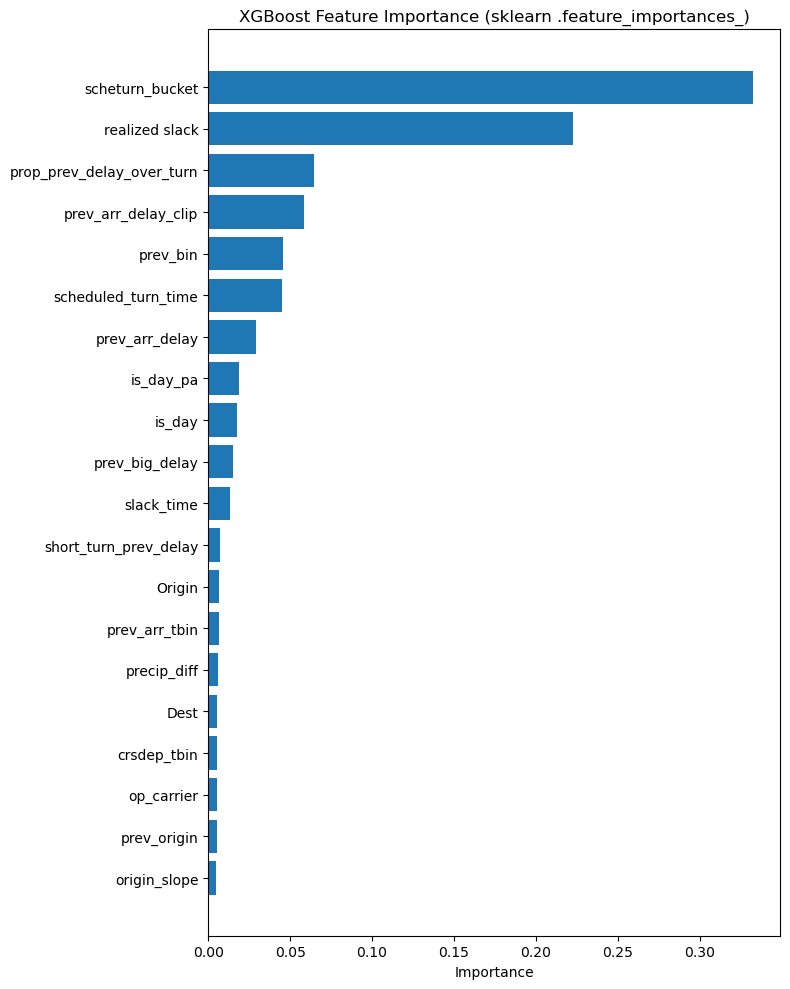

In [ ]:
topk = 20
topk_df = fi_df.head(topk).iloc[::-1]   

plt.figure(figsize=(8, 10))
plt.barh(topk_df["feature"], topk_df["importance"])
plt.title("XGBoost Feature Importance (sklearn .feature_importances_)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
